# Import library

In [ ]:
from PIL import Image
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Get Data

In [ ]:
!pip install wandb
from google.colab import drive 
drive.mount('/content/gdrive/')

     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 181 kB 51.2 MB/s 
     |████████████████████████████████| 145 kB 93.6 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=ae19f3dec221cf5195ab1893eb8c0e15e3b01e2e90baa377f22cd31e8c7ce0b8
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
Mounted at /content/gdrive/


In [ ]:
from glob import glob
train_file = glob(f'/content/gdrive/MyDrive/Colab Notebooks/cityspaces/train/*')
val_file = glob(f'/content/gdrive/MyDrive/Colab Notebooks/cityspaces/val/*')

In [ ]:
len(train_file), len(val_file)

(2975, 500)

(512, 256)
(512, 256)
(512, 256)
(512, 256)
(512, 256)


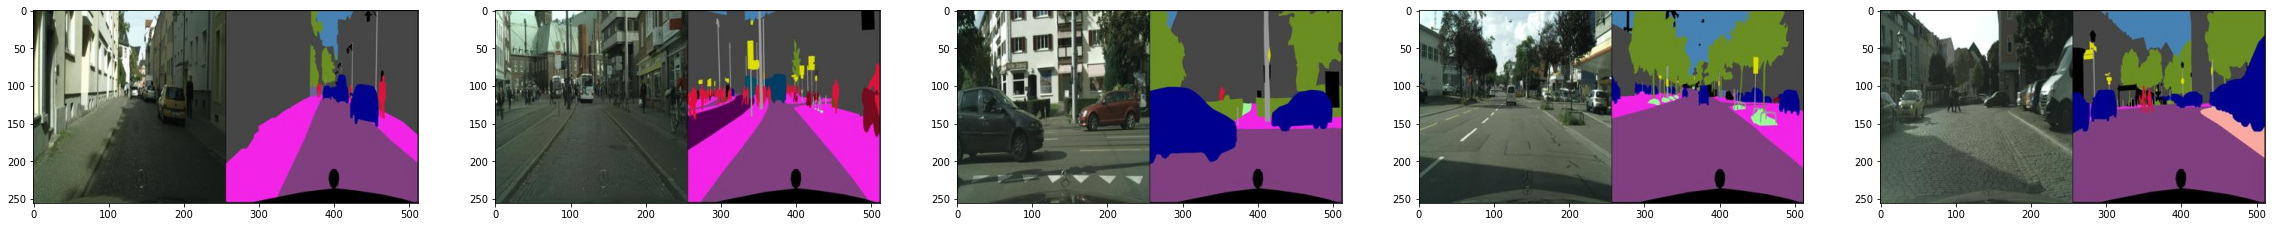

In [ ]:
plt.figure(figsize=(40,40)) # specifying the overall grid size

for i in range(5):
    plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
    img = Image.open(train_file[i])
    print(img.size)
    plt.imshow(img)

plt.show()

# Dataset Functions

In [ ]:
def splitTensor(sample):
        C, H, W = sample.shape
        
        input_image = sample[:,:,:int(W/2)]
        target_image = sample[:,:,int(W/2):]
        
        output = torch.cat([input_image,target_image])
        return output

In [ ]:
def make_two_tensor(sample):
  C, H, W = sample.shape   
  input_image = sample[:int(C/2),:,:]
  target_image = sample[int(C/2):,:,:] 

  return input_image, target_image

In [ ]:
def file_to_PIL(sample):
  
  result = Image.open(sample)

  return result

In [ ]:
def unnormalize(sample):
  sample = ((sample * 0.5) + 0.5)
  return sample

# Dataset

In [ ]:
image_height = 256
image_width = 256

In [ ]:
class CustomDatasest(Dataset):
  def __init__(self, np_data, transform = None):
      self.data = np_data
      self.transform = transform
      self.len = len(np_data)

  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    sample = self.data[idx]
    if self.transform:
      sample = self.transform(sample)
    return sample

In [ ]:
trans = transforms.Compose([
                            file_to_PIL,
                            transforms.ToTensor(),
                            transforms.Normalize(mean=0.5,std=0.5),
                            transforms.Resize((image_height, image_width * 2)),
                            splitTensor,
                            transforms.RandomHorizontalFlip(),
                            make_two_tensor,
                            ])

#TMP_loader

In [ ]:
tmp = val_file[:64]
tmp_set = CustomDatasest(tmp, transform = trans)
tmp_loader = DataLoader(
    dataset = tmp_set, 
    batch_size = 4,
    shuffle=True
)

In [ ]:
dataiter = iter(tmp_loader)
a, b = next(dataiter)
print(a.shape)
print(b.shape)

a.min(), a.max()

torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])


(tensor(-1.), tensor(1.))

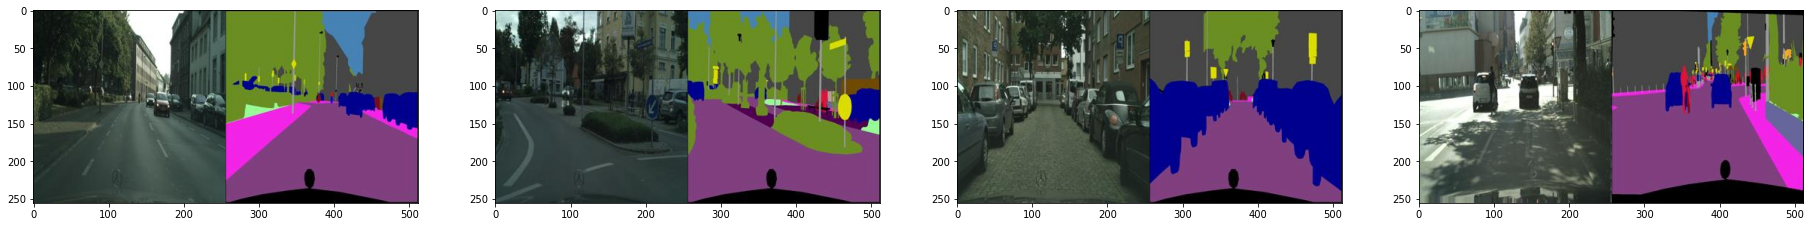

In [ ]:
plt.figure(figsize=(40,40)) # specifying the overall grid size
for i, (input, target) in enumerate(zip(a, b)):
  input_img = np.transpose(input.squeeze(), (1, 2, 0))
  target_img = np.transpose(target.squeeze(), (1, 2, 0))
  img = torch.cat([input_img, target_img], dim=1)
  img = unnormalize(img)
  plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
  plt.imshow(img)
plt.show()

#Create Model

In [ ]:
!pip install torchinfo
from torchinfo import summary

##Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, output_nc):
        super(Generator, self).__init__()

        self.downsample_layers = []
        # Downsampling
        in_features = 3
        out_features = 64
        
        input = nn.Sequential(*self.downsample(in_features,out_features,False))
        self.downsample_layers.append(input) #(128, 128, 64)

        in_features = out_features
        out_features = out_features * 2
        
        input = nn.Sequential(*self.downsample(in_features,out_features))
        self.downsample_layers.append(input) #(64, 64, 128)

        in_features = out_features
        out_features = out_features * 2
        
        input = nn.Sequential(*self.downsample(in_features,out_features))
        self.downsample_layers.append(input) # (32, 32, 256)

        in_features = out_features
        out_features = out_features * 2

        input = nn.Sequential(*self.downsample(in_features,out_features))
        self.downsample_layers.append(input) # (16, 16, 512)

        in_features = out_features

        self.downsample_layers.append(nn.Sequential(*self.downsample(in_features,out_features))) # (8, 8, 512)
        self.downsample_layers.append(nn.Sequential(*self.downsample(in_features,out_features))) # (4, 4, 512)
        self.downsample_layers.append(nn.Sequential(*self.downsample(in_features,out_features))) # (2, 2, 512)
        self.downsample_layers.append(nn.Sequential(*self.downsample(in_features,out_features))) # (1, 1, 512)

        self.downsample_layer = nn.Sequential(*self.downsample_layers)

        self.updsample_layers = []

        self.updsample_layers.append(nn.Sequential(*self.upsample(in_features,out_features, apply_dropout=True))) # (2, 2, 512)

        in_features = out_features * 2 # concat 1024

        self.updsample_layers.append(nn.Sequential(*self.upsample(in_features,out_features, apply_dropout=True))) # (4, 4, 512)
        self.updsample_layers.append(nn.Sequential(*self.upsample(in_features,out_features, apply_dropout=True))) # (8, 8, 512)
        self.updsample_layers.append(nn.Sequential(*self.upsample(in_features,out_features))) # (16, 16, 512)

        out_features = out_features // 2 # 256

        self.updsample_layers.append(nn.Sequential(*self.upsample(in_features,out_features))) # (32, 32, 256)

        in_features = out_features * 2 # 512
        out_features = out_features // 2 # 128

        self.updsample_layers.append(nn.Sequential(*self.upsample(in_features,out_features))) # (64, 64, 128)

        in_features = out_features * 2 # 256
        out_features = out_features // 2 #64

        self.updsample_layers.append(nn.Sequential(*self.upsample(in_features,out_features))) # (128, 128, 64)
        
        in_features = out_features * 2
        out_features = output_nc

        self.updsample_layer = nn.Sequential(*self.updsample_layers)

        self.output_layer = nn.Sequential(
                                           nn.ConvTranspose2d(in_features, out_features, 4, stride=2, padding=1),
                                           nn.Tanh(),
        )

    def downsample(self, in_features,out_features, apply_batchnorm=True):
      layerList = []
      layerList.append(nn.Conv2d(in_features, out_features, 4, stride=2, padding=1, bias=False))
      if apply_batchnorm:
        layerList.append(nn.BatchNorm2d(out_features))
      layerList.append(nn.LeakyReLU(0.3, inplace=True))

      return layerList

    def upsample(self, in_features,out_features, apply_dropout=True):
      layerList = []
      layerList.append(nn.ConvTranspose2d(in_features, out_features, 4, stride=2, padding=1, bias=False))

      
      layerList.append(nn.BatchNorm2d(out_features))
      if apply_dropout:
        layerList.append(nn.Dropout(0.2))
      layerList.append(nn.LeakyReLU(0.3, inplace=True))

      return layerList

    def forward(self, x):
      
      down_result = []
      for i, down in enumerate(self.downsample_layers):
        x = down(x)
        down_result.append(x)
      down_result = reversed(down_result[:-1])
      for up, down in zip(self.updsample_layers, down_result):
        x = up(x)
        x = torch.cat([x, down], dim=1)

      x = self.output_layer(x)
      return x

In [ ]:
x = torch.rand((1, 3, 256, 256))
generator = Generator(3)
generator.eval()
print(summary(generator, (2, 3, 256, 256), device='cpu'))
sample = generator(x)
print("G(x) shape:", sample.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                --                        --
├─Sequential: 1                          --                        --
│    └─Sequential: 2-1                   [2, 64, 128, 128]         --
│    │    └─Conv2d: 3-1                  [2, 64, 128, 128]         3,072
│    │    └─LeakyReLU: 3-2               [2, 64, 128, 128]         --
│    └─Sequential: 2-2                   [2, 128, 64, 64]          --
│    │    └─Conv2d: 3-3                  [2, 128, 64, 64]          131,072
│    │    └─BatchNorm2d: 3-4             [2, 128, 64, 64]          256
│    │    └─LeakyReLU: 3-5               [2, 128, 64, 64]          --
│    └─Sequential: 2-3                   [2, 256, 32, 32]          --
│    │    └─Conv2d: 3-6                  [2, 256, 32, 32]          524,288
│    │    └─BatchNorm2d: 3-7             [2, 256, 32, 32]          512
│    │    └─LeakyReLU: 3-8               [2, 256, 32, 32]          --


##Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        self.downsample_layers = []
        # Downsampling
        in_features = input_nc * 2
        out_features = 64
        
        input = nn.Sequential(*self.downsample(in_features,out_features,False))
        self.downsample_layers.append(input) #(128, 128, 64)

        in_features = out_features
        out_features = out_features * 2
        
        input = nn.Sequential(*self.downsample(in_features,out_features))
        self.downsample_layers.append(input) #(64, 64, 128)

        in_features = out_features
        out_features = out_features * 2
        
        input = nn.Sequential(*self.downsample(in_features,out_features))
        self.downsample_layers.append(input) # (32, 32, 256)

        self.downsample_layer = nn.Sequential(*self.downsample_layers)

        in_features = out_features
        out_features = out_features * 2

        self.zero_pad = nn.ZeroPad2d(1)

        self.conv1 = nn.Conv2d(in_features, out_features, 4, stride=1, bias=False)

        in_features = out_features

        self.batchnorm = nn.BatchNorm2d(out_features)
        self.leakyRelu = nn.LeakyReLU(0.3, inplace=True)
        self.conv2 = nn.Conv2d(in_features, 1, 4, stride=1)

    def downsample(self, in_features,out_features, apply_batchnorm=True):
      layerList = []
      layerList.append(nn.Conv2d(in_features, out_features, 4, stride=2, padding=1, bias=False))
      if apply_batchnorm:
        layerList.append(nn.BatchNorm2d(out_features))
      layerList.append(nn.LeakyReLU(0.3, inplace=True))

      return layerList

    def forward(self, inputImg, targetImg):
        x = torch.cat((inputImg,targetImg), dim=1)
        x = self.downsample_layer(x)
        x = self.zero_pad(x)
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.leakyRelu(x)
        x = self.zero_pad(x)
        x = self.conv2(x)
        return x

In [ ]:
x = torch.rand((2, 3, 256, 256))
generator = Generator(3)
discriminator = Discriminator(3)
sample = generator(x)
print(summary(discriminator, [(2, 3, 256, 256), (2, 3, 256, 256)],dtypes=[torch.float32, torch.float32], device='cpu'))
print("D(x) shape:", discriminator(x, sample).shape)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [2, 256, 32, 32]          --
│    └─Sequential: 2-1                   [2, 64, 128, 128]         --
│    │    └─Conv2d: 3-1                  [2, 64, 128, 128]         6,144
│    │    └─LeakyReLU: 3-2               [2, 64, 128, 128]         --
│    └─Sequential: 2-2                   [2, 128, 64, 64]          --
│    │    └─Conv2d: 3-3                  [2, 128, 64, 64]          131,072
│    │    └─BatchNorm2d: 3-4             [2, 128, 64, 64]          256
│    │    └─LeakyReLU: 3-5               [2, 128, 64, 64]          --
│    └─Sequential: 2-3                   [2, 256, 32, 32]          --
│    │    └─Conv2d: 3-6                  [2, 256, 32, 32]          524,288
│    │    └─BatchNorm2d: 3-7             [2, 256, 32, 32]          512
│    │    └─LeakyReLU: 3-8               [2, 256, 32, 32]          --


In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

#parameter

In [ ]:
from tqdm import tqdm
from pytz import timezone
from datetime import datetime
now = datetime.now(timezone('Asia/Seoul'))
print(now)

2022-05-17 22:44:41.579700+09:00


In [ ]:
BATCHSIZE = 8
EPOCHS = 200
lr = 0.002
LAMBDA = 100

load_model = False
load_model_file_name = f''

save_model = True
model_save_epoch = 10
save_model_fileName = f'pix2pix_model_{now}.pth'
model_root_folder = f'/content/gdrive/MyDrive/Colab Notebooks/cityspaces/pix2pix/'
save_model_path = model_root_folder + save_model_fileName
load_model_file = save_model_folder + load_model_file_name
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Data Loader

In [ ]:
custom_train_set = CustomDatasest(train_file, transform = trans)

train_loader = DataLoader(
    dataset = custom_train_set, 
    batch_size = BATCHSIZE,
    shuffle=True
)
device

device(type='cuda')

# Model 선언

In [ ]:
D = Discriminator(3)
G = Generator(3)
G.apply(weights_init_normal)
D.apply(weights_init_normal)
print("Done")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  import sys


Done


# Loss Functions & optimizer

In [ ]:
criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1 = nn.L1Loss()

In [ ]:
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5,0.999))
d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5,0.999))

#Load Model

In [ ]:
if load_model :
  checkpoint = torch.load(load_model_file, map_location=torch.device('cpu'))
  G.load_state_dict(checkpoint['g_model_state_dict'])
  D.load_state_dict(checkpoint['d_model_state_dict'])
  g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
  d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
  lr = checkpoint['lr']
  epoch = checkpoint['epoch']
  EPOCHS = EPOCHS  - epoch
print(EPOCHS)

# Test GAN

<Figure size 2880x2880 with 0 Axes>

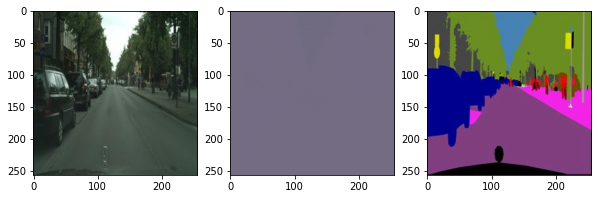

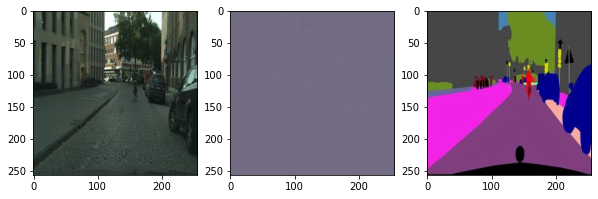

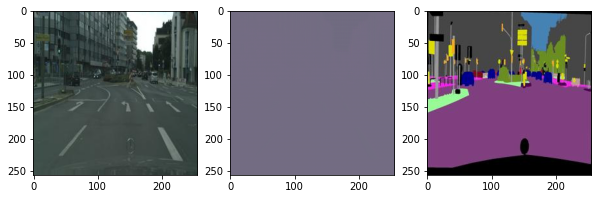

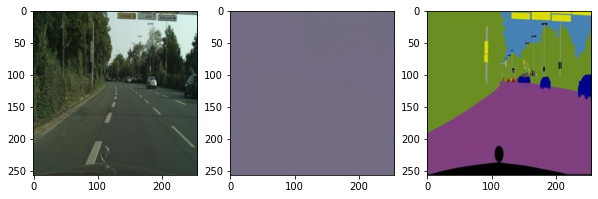

In [ ]:
dataiter = iter(tmp_loader)
a, b = next(dataiter)
plt.figure(figsize=(40,40)) # specifying the overall grid size
G.to(device)
G.eval()
for i, (input, target) in enumerate(zip(a, b)):
  input_img = np.transpose(input.squeeze(), (1, 2, 0))
  target_img = np.transpose(target.squeeze(), (1, 2, 0))
  input_tensor = input.unsqueeze(dim=0).to(device)
  fake_img = np.transpose(G(input_tensor).detach().cpu().numpy()[0] , (1, 2, 0))

  fig = plt.figure(figsize=(10,5))
  fig.add_subplot(131)
  plt.imshow(unnormalize(input_img)) 
  fig.add_subplot(132)
  plt.imshow(unnormalize(fake_img)) 
  fig.add_subplot(133)
  plt.imshow(unnormalize(target_img)) 
plt.show()

#wandb 설정

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
config = {
  "learning_rate": lr,
  "epochs": EPOCHS,
  "batch_size": BATCHSIZE
}
wandb.init(project="testPix2pix", entity="nek0", config=config)
wandb.run.name = 'Date : '+str(now)

wandb: Currently logged in as: nek0. Use `wandb login --relogin` to force relogin


#Traning

In [ ]:
G.to(device)
D.to(device)
G.train()
D.train()
iter_num = int(len(train_loader.dataset)/BATCHSIZE) + 1.
torch.autograd.set_detect_anomaly(True)
for epoch in range(EPOCHS):
  progress_bar = tqdm(train_loader)

  total_G_loss = 0
  total_D_loss = 0
  total_G_L1_loss = 0
  total_gen_loss = 0

  for i, (input_img, target_img) in enumerate(progress_bar):
    
    input_img = input_img.to(device)
    target_img = target_img.to(device)

    d_optimizer.zero_grad()

    fake_images = G(input_img)
    disc_real_output = D(input_img, target_img)
    disc_fake_output = D(input_img, fake_images.detach())

    real_label = torch.ones_like(disc_real_output, requires_grad=False).to(device)
    fake_label = torch.zeros_like(disc_fake_output, requires_grad=False).to(device)

    disc_real_loss = criterion_GAN(disc_real_output, real_label)
    disc_fake_loss = criterion_GAN(disc_fake_output, fake_label)
    loss_D = (disc_real_loss + disc_fake_loss) * 0.5

    loss_D.backward()
    d_optimizer.step()
    
    
    g_optimizer.zero_grad()

    fake_images = G(input_img)
    disc_fake_output = D(input_img, fake_images)

    gen_loss = criterion_GAN(disc_fake_output, real_label)
    l1_loss = criterion_L1(fake_images, target_img)
    loss_G = gen_loss + (LAMBDA * l1_loss)

    loss_G.backward()
    g_optimizer.step()
    
    total_G_loss += loss_G.item()
    total_D_loss += loss_D.item()
    total_G_L1_loss += l1_loss.item()
    total_gen_loss += gen_loss.item()

    # 학습 진행 알아보기
  if save_model and epoch % model_save_epoch == 0:
    torch.save({
              'g_model_state_dict': G.state_dict(),
              'd_model_state_dict': D.state_dict(),
              'g_optimizer_state_dict': g_optimizer.state_dict(),
              'd_optimizer_state_dict': d_optimizer.state_dict(),
              'lr': lr,
              'epoch': epoch,
              }, save_model_path)
    
  with torch.no_grad():
    tmp_fake = unnormalize(np.transpose(G(input_img).detach().cpu().numpy()[0] , (1, 2, 0)))
    tmp_input = unnormalize(np.transpose(input_img.detach().cpu().numpy()[0] , (1, 2, 0)))
    tmp_real = unnormalize(np.transpose(target_img.detach().cpu().numpy()[0] , (1, 2, 0)))

    wandb.log({
        "Input Image": wandb.Image(tmp_input),
        "Generate Image": wandb.Image(tmp_fake),
        "Target Image": wandb.Image(tmp_real),
        "Total Generator loss": total_G_loss / iter_num,
        "Total Discriminator loss": total_D_loss / iter_num,
        "G L1 Loss": total_G_L1_loss / iter_num,
        "Gen loss": total_gen_loss / iter_num,
    })
  print('Epoch [{}/{}]' 
        .format(epoch, EPOCHS))

100%|██████████| 186/186 [15:19<00:00,  4.94s/it]


Epoch [0/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [1/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [2/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [3/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [4/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [5/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [6/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [7/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [8/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [9/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [10/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [11/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [12/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [13/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [14/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [15/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [16/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [17/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [18/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [19/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [20/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [21/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [22/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [23/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [24/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [25/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [26/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [27/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [28/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [29/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [30/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [31/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [32/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [33/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [34/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [35/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [36/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [37/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [38/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [39/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [40/200]


100%|██████████| 186/186 [01:35<00:00,  1.96it/s]


Epoch [41/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [42/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [43/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [44/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [45/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [46/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [47/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [48/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [49/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [50/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [51/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [52/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [53/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [54/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [55/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [56/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [57/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [58/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [59/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [60/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [61/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [62/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [63/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [64/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [65/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [66/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [67/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [68/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [69/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [70/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [71/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [72/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [73/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [74/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [75/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [76/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [77/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [78/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [79/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [80/200]


100%|██████████| 186/186 [01:36<00:00,  1.93it/s]


Epoch [81/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [82/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [83/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [84/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [85/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [86/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [87/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [88/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [89/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [90/200]


100%|██████████| 186/186 [01:35<00:00,  1.96it/s]


Epoch [91/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [92/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [93/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [94/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [95/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [96/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [97/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [98/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [99/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [100/200]


100%|██████████| 186/186 [01:35<00:00,  1.95it/s]


Epoch [101/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [102/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [103/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [104/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [105/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [106/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [107/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [108/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [109/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [110/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [111/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [112/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [113/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [114/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [115/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [116/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [117/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [118/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [119/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [120/200]


100%|██████████| 186/186 [01:35<00:00,  1.94it/s]


Epoch [121/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [122/200]


100%|██████████| 186/186 [01:35<00:00,  1.96it/s]


Epoch [123/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [124/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [125/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [126/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [127/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [128/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [129/200]


100%|██████████| 186/186 [01:35<00:00,  1.95it/s]


Epoch [130/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [131/200]


100%|██████████| 186/186 [01:35<00:00,  1.96it/s]


Epoch [132/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [133/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [134/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [135/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [136/200]


100%|██████████| 186/186 [01:35<00:00,  1.95it/s]


Epoch [137/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [138/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [139/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [140/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [141/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [142/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [143/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [144/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [145/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [146/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [147/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [148/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [149/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [150/200]


100%|██████████| 186/186 [01:35<00:00,  1.96it/s]


Epoch [151/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [152/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [153/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [154/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [155/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [156/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [157/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [158/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [159/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [160/200]


100%|██████████| 186/186 [01:35<00:00,  1.95it/s]


Epoch [161/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [162/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [163/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [164/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [165/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [166/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [167/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [168/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [169/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [170/200]


100%|██████████| 186/186 [01:35<00:00,  1.95it/s]


Epoch [171/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [172/200]


100%|██████████| 186/186 [01:35<00:00,  1.95it/s]


Epoch [173/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [174/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [175/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [176/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [177/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [178/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [179/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [180/200]


100%|██████████| 186/186 [01:35<00:00,  1.95it/s]


Epoch [181/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [182/200]


100%|██████████| 186/186 [01:35<00:00,  1.95it/s]


Epoch [183/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [184/200]


100%|██████████| 186/186 [01:35<00:00,  1.96it/s]


Epoch [185/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [186/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [187/200]


100%|██████████| 186/186 [01:35<00:00,  1.96it/s]


Epoch [188/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [189/200]


100%|██████████| 186/186 [01:35<00:00,  1.95it/s]


Epoch [190/200]


100%|██████████| 186/186 [01:35<00:00,  1.96it/s]


Epoch [191/200]


100%|██████████| 186/186 [01:35<00:00,  1.96it/s]


Epoch [192/200]


100%|██████████| 186/186 [01:35<00:00,  1.96it/s]


Epoch [193/200]


100%|██████████| 186/186 [01:34<00:00,  1.97it/s]


Epoch [194/200]


100%|██████████| 186/186 [01:35<00:00,  1.95it/s]


Epoch [195/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]


Epoch [196/200]


100%|██████████| 186/186 [01:35<00:00,  1.96it/s]


Epoch [197/200]


100%|██████████| 186/186 [01:35<00:00,  1.95it/s]


Epoch [198/200]


100%|██████████| 186/186 [01:34<00:00,  1.96it/s]

Epoch [199/200]
